In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import re
import random
import altair as alt

In [23]:
df_all = pd.read_csv('../data/all_job.csv')

df_all['Job Type'] = df_all['search'].apply(lambda text: re.sub(r'-\d+$', '', text).replace('-', ' ').title())
df_all['Job Type'] = df_all['Job Type'].replace('Time Series Analysis', 'Time Series')

In [24]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess text with stemming and lemmatization
def preprocess(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    return ' '.join(lemmatized_words)

# Apply preprocessing to the 'Qualifications' column
df_all['Qualifications_processed'] = df_all['Qualifications'].apply(preprocess)

# Define original keywords
keywords = ['R', 'Python', 'NLP', 'SQL', 'Cloud', 'Deep Learning', 'Solidity', 'Visualization', 'Optimization', 'Financial']

# Search for original keywords in preprocessed text
for keyword in keywords:
    if keyword == 'R':
        df_all[keyword] = np.where(df_all['Qualifications'].str.contains(r'\bR\b'), True, False)
    else:
        df_all[keyword] = np.where(df_all['Qualifications_processed'].str.contains(preprocess(keyword), case=False), True, False)


In [25]:
df = df_all[keywords]

In [26]:
import warnings
warnings.filterwarnings("ignore")

counts = pd.DataFrame(index=df.columns, columns=df.columns)
for col_x in df.columns:
    for col_y in df.columns:
        counts.at[col_x, col_y] = df[(df[col_x] == True) & (df[col_y] == True)].shape[0]

# Convert counts to tidy format
df_counts = counts.stack().reset_index()
df_counts.columns = ['x', 'y', 'count']

# Create heatmap using Altair
heatmap = alt.Chart(df_counts).mark_rect().encode(
    x=alt.X('x:O', axis=alt.Axis(title='X')),
    y=alt.Y('y:O', axis=alt.Axis(title='Y')),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='bluepurple')),
    tooltip=["x:O", "y:O", 'count:Q']
).properties(
    width=600,
    height=600,
    title='Heatmap of Skills Occurrences in Job Qualification'
)

heatmap


alt.Chart(...)

In [27]:
from apyori import apriori
import networkx as nx
import matplotlib.pyplot as plt


transactions = []
for _, row in df.iterrows():
    transaction = [column for column in row.index if row[column]]
    transactions.append(transaction)
    

In [28]:
def reformat_results(result):

    keep = []
    for i in range(0, len(result)):
        for j in range(0, len(list(result[i]))):
            if (j == 1):
                supp = result[i][j]
            if (j > 1):
                for k in range(0, len(list(result[i][j]))):
                    rhs = list(result[i][j][k][0])
                    if rhs:
                        lhs = list(result[i][j][k][1])
                        conf = float(result[i][j][k][2])
                        lift = float(result[i][j][k][3])
                        keep.append([rhs, lhs, supp, conf, supp*conf, lift])
    
    return  pd.DataFrame(keep, columns = ["rhs", "lhs", "supp", "conf", "supp x conf", "lift"])


def convert_to_network(df):


    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="+".join(row[1][0])
        rhs="+".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

def plot_network(G):

    random.seed(10)
    np.random.seed(10)
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edge_color=colors_e,
    node_size=4000,
    linewidths=2,
    font_size=8,
    font_color="black",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    edge_labels = {(u, v): "{:.4f}".format(G[u][v]['weight']) for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    ax.set(title='Skills in Qualification Association Rule Mining')
    plt.show()

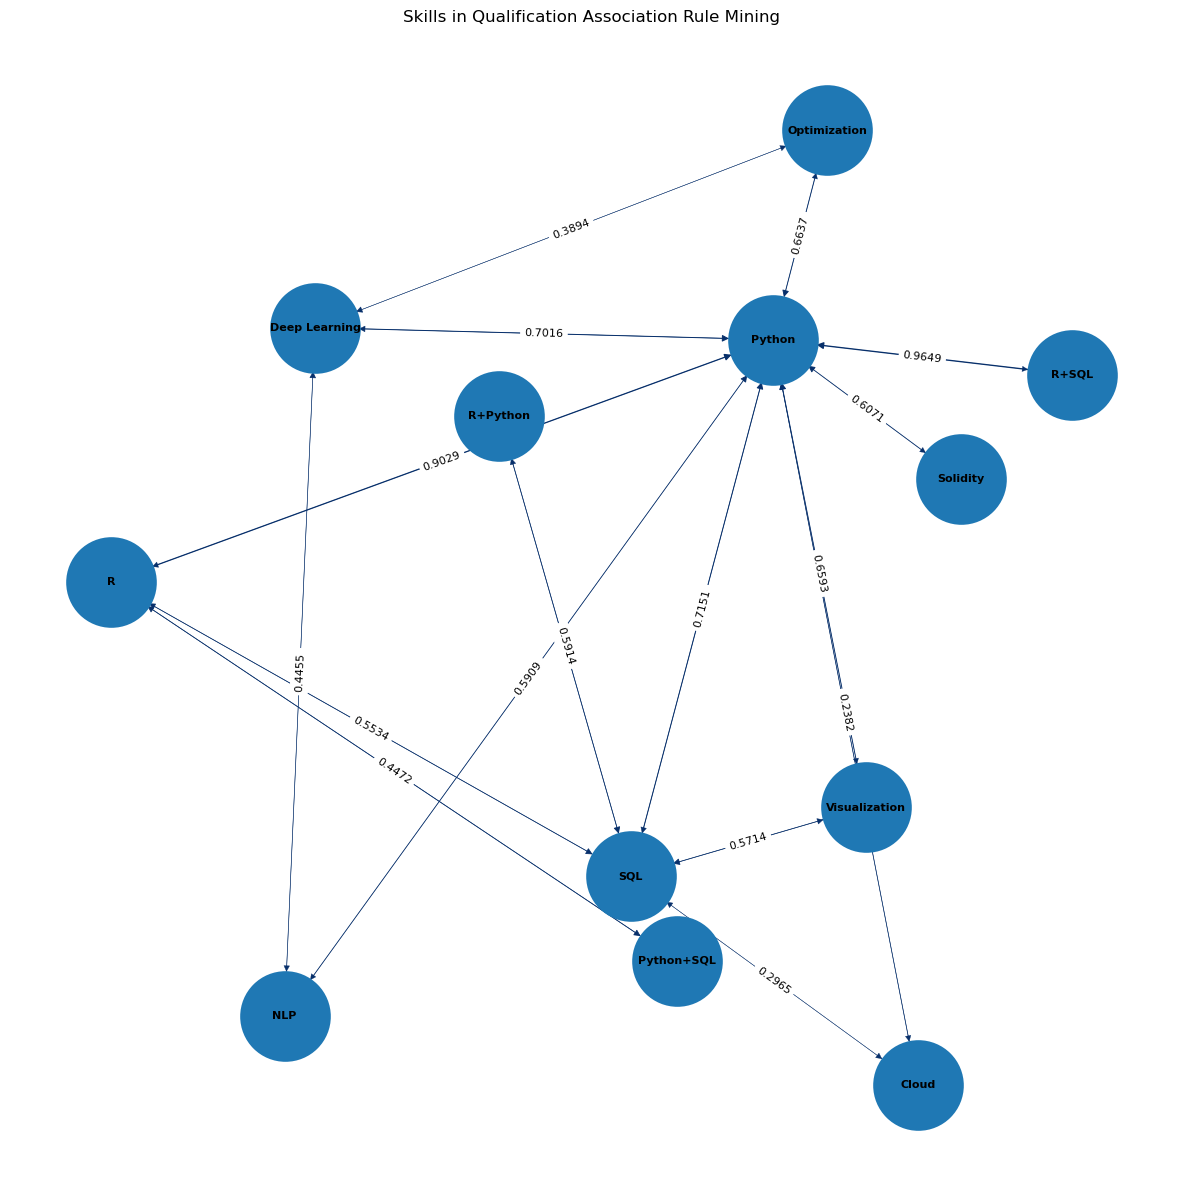

In [29]:
results = list(apriori(transactions, min_support = 0.05, min_confidence = 0.05, min_length = 1, max_length = 5))
results_reforated = reformat_results(results)
results_net = convert_to_network(results_reforated)
plot_network(results_net)

In [91]:
import plotly.graph_objects as go
import plotly.colors

dimensions_objs = []
for dim_name in keywords:
    dim_values = df_all[dim_name]
    dimension_obj = go.parcats.Dimension(
        values=dim_values,
        label=dim_name
    )
    dimensions_objs.append(dimension_obj)

job_type_dim = go.parcats.Dimension(
    values=df_all['Job Type'], label="Outcome", categoryarray=df_all['Job Type'].unique().astype(str),
)

dimensions_objs.append(job_type_dim)

unique_type = df_all['Job Type'].unique()

type_mapping = {}

for i, type in enumerate(unique_type):
    type_mapping[type] = i + 1




fig = go.Figure(data=[
    go.Parcats(
        dimensions=dimensions_objs,
        line={"color": df_all['Job Type'].map(type_mapping), 'colorscale': 'Spectral'},
        hoveron='color',
        hoverinfo='count+probability',
        labelfont={'size': 18, 'family': 'Times'},
        tickfont={'size': 16, 'family': 'Times'},
        arrangement='freeform',
    )
])



fig.update_layout(height=500)
fig.update_layout(title = "Parallel Flow Analysis from Skills To Job Type")
fig.show()
